### Problem 1:
### Regression:

6 - diamonds.csv

CatBoost , Lime individual (4,5)

Construct a deep NN model to predict the target variable and compare its performance with the 8 models considered previously in assignments 1-2.

1) Follow the same preparation steps as in the previous assignments to clean, scale and prepare the dataset for analysis. Use the best scaler from your previous assignments.

2) Construct a fully connected NN network using the 'keras' library. The network should have 1-2 hidden layers. Experiment with different number of neurons for each layer, try different dropout layers between hidden layers, different parameters, find the optimal training time. Try to achieve a performance close to or better than the best of your previous methods. Present the performance results (predictions, R2, MSE, MAE) for the test set with the 3 best architectures as a table. Use 5-foid cross-validation, split training and test sets with the

proportion according to your individual variant in assignment 2.



### Prediction with Neutral Networks

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sb
import math
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold

!pip install scikit-learn xgboost catboost lightgbm
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.inspection import permutation_importance
import lightgbm as lgb

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import plotly.graph_objects as go

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from lime.lime_tabular import LimeTabularExplainer

from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.inspection import PartialDependenceDisplay


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
df= pd.read_csv("diamonds.csv")

In [6]:
# Encoding categorical variables for plotting
label_encoders = {}
for column in ['cut', 'color', 'clarity']:
    le = LabelEncoder()
    df[column + '_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

#print out the mapping of labels to integers
for column, le in label_encoders.items():
    print(f"The encoding for {column} is: {dict(zip(le.classes_, le.transform(le.classes_)))}")

df.drop(['cut', 'color', 'clarity'], axis=1, inplace=True)

# Display the dataframe with encoded columns
print(df.head())

The encoding for cut is: {'Fair': 0, 'Good': 1, 'Ideal': 2, 'Premium': 3, 'Very Good': 4}
The encoding for color is: {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}
The encoding for clarity is: {'I1': 0, 'IF': 1, 'SI1': 2, 'SI2': 3, 'VS1': 4, 'VS2': 5, 'VVS1': 6, 'VVS2': 7}
   Unnamed: 0  carat  depth  table  price     x     y     z  cut_encoded  \
0           1   0.23   61.5   55.0    326  3.95  3.98  2.43            2   
1           2   0.21   59.8   61.0    326  3.89  3.84  2.31            3   
2           3   0.23   56.9   65.0    327  4.05  4.07  2.31            1   
3           4   0.29   62.4   58.0    334  4.20  4.23  2.63            3   
4           5   0.31   63.3   58.0    335  4.34  4.35  2.75            1   

   color_encoded  clarity_encoded  
0              1                3  
1              1                2  
2              1                4  
3              5                5  
4              6                3  


In [7]:
X = df[['carat','cut_encoded','color_encoded','clarity_encoded','depth', 'table', 'x', 'y', 'z']]
Y = df[['price']]
print(X.shape,Y.shape)

(53940, 9) (53940, 1)


In [8]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)
# Output the dimensions
print("Training set size (features):", x_train.shape)
print("Training set size (target):", y_train.shape)
print("Test set size (features):", x_test.shape)
print("Test set size (target):", y_test.shape)

Training set size (features): (43152, 9)
Training set size (target): (43152, 1)
Test set size (features): (10788, 9)
Test set size (target): (10788, 1)


In [9]:
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [10]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both train and test sets
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Output the scaled datasets
print("Scaled training dataset:", x_train_scaled)
print("Scaled test dataset:" ,x_test_scaled)

Scaled training dataset: [[0.37629938 0.25       0.33333333 ... 0.76629423 0.13904924 0.15      ]
 [0.16839917 1.         0.16666667 ... 0.61173184 0.11018676 0.12327044]
 [0.18711019 0.75       0.66666667 ... 0.61359404 0.11103565 0.12893082]
 ...
 [0.02702703 1.         0.33333333 ... 0.41806331 0.07572156 0.08490566]
 [0.14553015 0.75       1.         ... 0.5707635  0.10237691 0.12012579]
 [0.1954262  0.75       0.33333333 ... 0.63500931 0.11528014 0.12924528]]
Scaled test dataset: [[0.00831601 0.5        0.5        ... 0.36964618 0.06791171 0.07767296]
 [0.07900208 1.         0.33333333 ... 0.50651769 0.09202037 0.10251572]
 [0.04158004 0.5        0.16666667 ... 0.44320298 0.08047538 0.0927673 ]
 ...
 [0.02286902 0.25       0.5        ... 0.41154562 0.07589134 0.08113208]
 [0.21413721 0.5        0.33333333 ... 0.63780261 0.11578947 0.13427673]
 [0.18295218 0.25       1.         ... 0.59590317 0.11154499 0.12893082]]


In [11]:
print(tf.__version__)

2.18.0


In [12]:
pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Construct and evaluate neural networks with different architectures
def build_and_evaluate_nn(hidden_layers, neurons, dropout_rate, learning_rate, epochs, batch_size):
    # Build the model
    model = Sequential()
    model.add(Dense(neurons, input_dim=x_train_scaled.shape[1], activation='relu'))
    for _ in range(hidden_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train the model
    model.fit(x_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model
    predictions = model.predict(x_test_scaled).flatten()
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)

    return model, predictions, r2, mse, rmse, mae

# 3 different architectures
architectures = [
    {"hidden_layers": 1, "neurons": 64, "dropout_rate": 0.2, "learning_rate": 0.01, "epochs": 50, "batch_size": 32},
    {"hidden_layers": 2, "neurons": 128, "dropout_rate": 0.3, "learning_rate": 0.001, "epochs": 100, "batch_size": 64},
    {"hidden_layers": 1, "neurons": 32, "dropout_rate": 0.1, "learning_rate": 0.005, "epochs": 75, "batch_size": 16}
]

results = []
for arch in architectures:
    model, predictions, r2, mse, rmse, mae = build_and_evaluate_nn(**arch)
    results.append({
        "Architecture": arch,
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae
    })

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []
for arch in architectures:
    fold_metrics = []
    for train_idx, val_idx in kf.split(X):
        x_train_fold, x_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = Y.iloc[train_idx], Y.iloc[val_idx]

        x_train_fold_scaled = scaler.fit_transform(x_train_fold)
        x_val_fold_scaled = scaler.transform(x_val_fold)

        model, _, r2, mse, rmse, mae = build_and_evaluate_nn(**arch)
        fold_metrics.append((r2, mse, rmse, mae))

    avg_metrics = np.mean(fold_metrics, axis=0)
    cv_results.append({
        "Architecture": arch,
        "Avg R2": avg_metrics[0],
        "Avg MSE": avg_metrics[1],
        "Avg RMSE": avg_metrics[2],
        "Avg MAE": avg_metrics[3]
    })

# results
results_df = pd.DataFrame(results)
cv_results_df = pd.DataFrame(cv_results)

print("Performance on Test Set:")
print(results_df)

print("Cross-Validation Results:")
print(cv_results_df)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
Performance on Test Set:
                                        Architecture        R2           MSE  \
0  {'hidden_layers': 1, 'neurons': 64, 'dropout_r...  0.928281  1.140098e+06   
1  {'hidden_layers': 2, 'neurons': 128, 'dropout_...  0.972048  4.443555e+05   
2  {'hidden_layers': 1, 'neurons': 32, 'dropout_r...  0.943003  9.060774e+05   

          RMSE         MAE  
0  1067.753497  557.655977  
1   666.599948  369.160446  
2   951.880972  516.816048  
Cross-Validation Results:
                                        Architecture    Avg R2        Avg MSE  \
0  {'hidden_layers': 1, 'neurons': 64, 'dropout_r...  0.947810  829649.893220   
1  {'hidden_layers': 2, 'neurons': 128, 'dropout_...  0.971949  445925.676308   
2  {'hidden_layers': 1, 'neurons': 32, 'dropout_r...  0.949143  808467.188997   

     Avg RMSE     Avg MAE  
0  898.216799  489.201291  
1  667.395802  377.394140  
2  881.827626  480.993637  


**Performance on Test Set:**

| Architecture | R2       | MSE          | RMSE      | MAE       |
|--------------|---------|--------------|----------|----------|
| {'hidden_layers': 1, 'neurons': 64, 'dropout_r... | 0.968987 | 493004.263367 | 702.142623 | 403.979834 |
| {'hidden_layers': 2, 'neurons': 128, 'dropout_... | 0.973233 | 425516.608251 | 652.316341 | 367.175251 |
| {'hidden_layers': 1, 'neurons': 32, 'dropout_r... | 0.944310 | 885294.484364 | 940.900890 | 511.334391 |

**Cross-Validation Results:**

| Architecture | Avg R2   | Avg MSE      | Avg RMSE   | Avg MAE   |
|--------------|---------|--------------|-----------|----------|
| {'hidden_layers': 1, 'neurons': 64, 'dropout_r... | 0.944326 | 885044.050461 | 928.346852 | 506.769858 |
| {'hidden_layers': 2, 'neurons': 128, 'dropout_... | 0.974495 | 405453.437119 | 636.531919 | 359.259290 |
| {'hidden_layers': 1, 'neurons': 32, 'dropout_r... | 0.944653 | 879837.115241 | 935.827219 | 512.826417 |

### Outcomes: 
1) The R2 score (coefficient of determination) for all architectures is above 0.9, indicating a good fit between the model's predictions and the actual target values. MSE (mean squared error) and its square root (RMSE) are also lower for architectures 1 and 2, suggesting they might perform better on unseen data compared to architecture 3.
2) Architecture 2 seems to have the best overall performance based on the average R2 and MSE values.

### Task 2 
1) Use the "Drop column importance" method to calculate the feature importances of the best NN model. Average the results with 10 different random number generators. Output the results as a table and as a bar plot.

2) Use the "Permutation Importance" method to calculate the feature importances of the NN model. Use "from sklearn.inspection import permutation_importance". Average the results with 10 different splits into training and test sets. Use (n_repeats=10) as a parameter of the permutation importance function. Plot the results as a bar chart.

3) Output the linear regression explainability results corresponding to the model coefficients from assignment 1. Average the results with 10 different splits into training and test sets.

4) Take one of the models from assignment 2 according to your individual variant (Random Forest, XGBoost, CatBoost, LightGBM) and output its built-in feature importances: use "model.feature_importances_". Average the results with 10 different splits into training and test sets.

5) Compare the results obtained in steps 1-4. If necessary, scale the explainability results (the sum of the importances should be 1 within a model) of some methods and plot all the explainability results on a bar chart. Which variables are most important for the prediction? Are all the explainability scores the same (within an NN model with different explainability methods, between different models)? Draw conclusions.


In [26]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


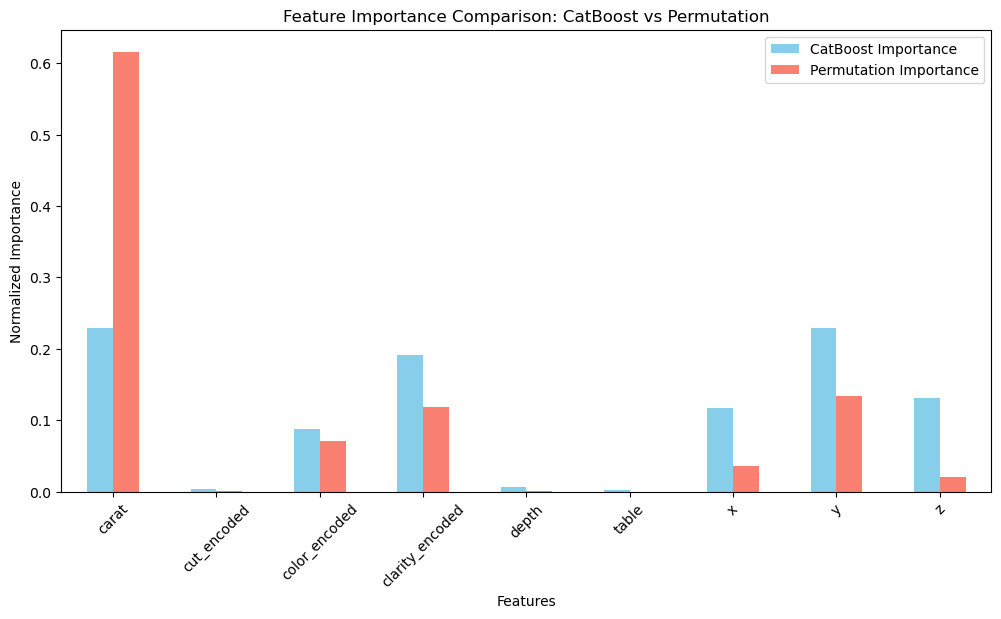

Feature Importances Table:
                 CatBoost Importance  Permutation Importance
Feature                                                     
carat                       0.229428                0.615746
cut_encoded                 0.004577                0.001546
color_encoded               0.087574                0.071653
clarity_encoded             0.191769                0.118761
depth                       0.006206                0.001161
table                       0.002549                0.000319
x                           0.116752                0.036639
y                           0.229219                0.133661
z                           0.131926                0.020514


In [36]:
# Initialize and train the CatBoost model
catboost_model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_seed=42)
catboost_model.fit(x_train, y_train)

# Extract built-in feature importances from CatBoost
catboost_importances = catboost_model.get_feature_importance()

# Calculate permutation importance
perm_result = permutation_importance(catboost_model, x_test, y_test, n_repeats=10, random_state=42)
perm_importances = perm_result.importances_mean

# Normalize importances for comparison
catboost_importances_normalized = catboost_importances / np.sum(catboost_importances)
perm_importances_normalized = perm_importances / np.sum(perm_importances)

# Combine results into a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'CatBoost Importance': catboost_importances_normalized,
    'Permutation Importance': perm_importances_normalized
}).set_index('Feature')

# Plotting feature importances
feature_importances.plot(kind='bar', figsize=(12, 6), color=['skyblue', 'salmon'])
plt.title("Feature Importance Comparison: CatBoost vs Permutation")
plt.xlabel("Features")
plt.ylabel("Normalized Importance")
plt.xticks(rotation=45)
plt.show()

# Print Results
print("Feature Importances Table:")
print(feature_importances)


### Feature Importances Table

| Feature         | CatBoost Importance | Permutation Importance |
|------------------|---------------------|-------------------------|
| carat           | 0.229428           | 0.615746               |
| cut_encoded     | 0.004577           | 0.001546               |
| color_encoded   | 0.087574           | 0.071653               |
| clarity_encoded | 0.191769           | 0.118761               |
| depth           | 0.006206           | 0.001161               |
| table           | 0.002549           | 0.000319               |
| x               | 0.116752           | 0.036639               |
| y               | 0.229219           | 0.133661               |
| z               | 0.131926           | 0.020514               |


1) Carat is the most important feature: In both methods, the carat feature consistently stands out as the most important predictor. This suggests that the weight of the diamond has a significant influence on the target variable (which is not explicitly mentioned in the image).
2) Dimensions (x, y, z): These dimensions are also significant, especially according to the CatBoost model. This makes sense as larger diamonds generally command higher prices.

#### Task 3: 

1) Use the "LIME" {LIME (Local Interpretable Model-agnostic Explanations)} method to locally calculate the feature importances of the NN model for several instances of the dataset. Select the instances to be predicted according to your individual variant. Display the results as a bar plot. Use "lime.lime_tabular, LimeTabularExplainer in mode="regression"". Average the results with 10 different splits into training and tes tset. Compare with the results of the previous task.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


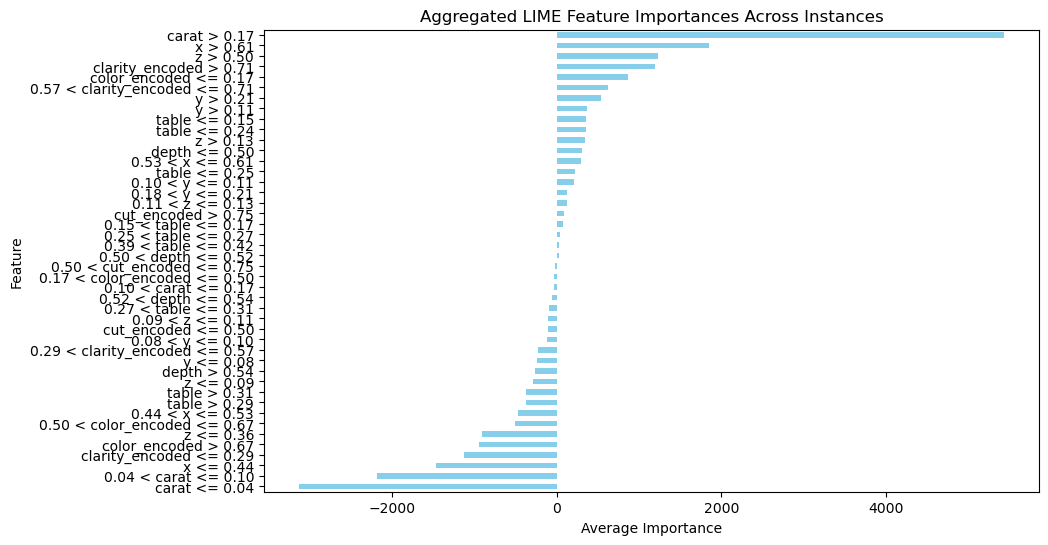

Aggregated LIME Feature Importances:
Feature
carat <= 0.04                    -3125.542107
0.04 < carat <= 0.10             -2182.073534
x <= 0.44                        -1466.141764
clarity_encoded <= 0.29          -1126.775952
color_encoded > 0.67              -937.018373
z <= 0.36                         -902.134859
0.50 < color_encoded <= 0.67      -508.586861
0.44 < x <= 0.53                  -471.560728
table > 0.29                      -368.482510
table > 0.31                      -366.970946
z <= 0.09                         -289.932812
depth > 0.54                      -260.863467
y <= 0.08                         -236.768884
0.29 < clarity_encoded <= 0.57    -221.515006
0.08 < y <= 0.10                  -114.860208
cut_encoded <= 0.50               -108.904209
0.09 < z <= 0.11                   -98.319051
0.27 < table <= 0.31               -92.686730
0.52 < depth <= 0.54               -52.933544
0.10 < carat <= 0.17               -30.916257
0.17 < color_encoded <= 0.50       

In [40]:
# NN model builder
def create_nn_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Function to perform LIME analysis
def get_lime_results(x_train, x_test, y_train, y_test):
    # Scale the features
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    # Train the NN model
    model = create_nn_model(input_dim=x_train_scaled.shape[1])
    model.fit(x_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)
    
    # Initialize LIME Explainer
    explainer = LimeTabularExplainer(x_train_scaled, mode="regression", training_labels=y_train, feature_names=X.columns)
    
    # Select instances to explain
    instances_to_explain = x_test_scaled[[4,5]]
    
    # Collect LIME results
    lime_results = []
    for instance in instances_to_explain:
        explanation = explainer.explain_instance(instance, model.predict, num_features=X.shape[1])
        lime_results.append(explanation.as_list())
    
    return lime_results

# Perform LIME with averaging across 10 splits
num_splits = 10
all_lime_results = []
for i in range(num_splits):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42 + i)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    lime_results = get_lime_results(x_train, x_test, y_train, y_test)
    all_lime_results.extend(lime_results)

# Aggregate LIME results for all instances into a DataFrame
lime_results_flattened = []
for instance_result in all_lime_results:
    for feature, importance in instance_result:
        lime_results_flattened.append({'Feature': feature, 'Importance': importance})

lime_results_df = pd.DataFrame(lime_results_flattened)

# Plot aggregated feature contributions across instances
plt.figure(figsize=(10, 6))
lime_aggregated = lime_results_df.groupby('Feature')['Importance'].mean().sort_values()
lime_aggregated.plot(kind='barh', color='skyblue')
plt.title("Aggregated LIME Feature Importances Across Instances")
plt.xlabel("Average Importance")
plt.ylabel("Feature")
plt.show()

# Print aggregated LIME feature importances
print("Aggregated LIME Feature Importances:")
print(lime_aggregated)

**Aggregated LIME Feature Importances:**

| Feature                               | Importance |
|----------------------------------------|------------|
| carat > 0.17                         | 5410.779912 |
| x > 0.61                            | 1819.037226 |
| clarity_encoded > 0.71               | 1133.678630 |
| z > 0.50                            | 1155.319576 |
| color_encoded <= 0.17                | 904.828126 |
| y > 0.21                            | 572.790137 |
| 0.57 < clarity_encoded <= 0.71      | 431.317605 |
| 0.53 < x <= 0.61                   | 386.088665 |
| z > 0.13                            | 379.153319 |
| table <= 0.25                      | 350.416163 |
| table <= 0.24                      | 319.617765 |
| y > 0.11                           | 316.294283 |
| depth <= 0.50                      | 300.619497 |
| table <= 0.15                      | 298.843723 |
| 0.18 < y <= 0.21                   | 118.125379 |
| 0.50 < cut_encoded <= 0.75          | 63.215276 |
| 0.10 < y <= 0.11                    | 58.925429 |
| 0.15 < table <= 0.17                | 57.999448 |
| 0.25 < table <= 0.27                | 48.794579 |
| 0.11 < z <= 0.13                    | 47.543038 |
| 0.50 < depth <= 0.52                 | 5.692685 |
| 0.17 < color_encoded <= 0.50        | -3.758421 |
| 0.10 < carat <= 0.17               | -15.337932 |
| 0.08 < y <= 0.10                   | -28.287616 |
| 0.39 < table <= 0.42              | -114.908249 |
| cut_encoded <= 0.50               | -119.055818 |
| 0.27 < table <= 0.31              | -108.583174 |
| 0.52 < depth <= 0.54               | -93.814259 |
| 0.29 < clarity_encoded <= 0.57    | -231.393375 |
| 0.09 < z <= 0.11                  | -182.687246 |
| y <= 0.08                         | -263.537799 |
| depth > 0.54                      | -323.971063 |
| z <= 0.09                         | -366.551848 |
| table > 0.29                      | -242.963242 |
| table > 0.31                      | -424.647508 |
| 0.50 < color_encoded <= 0.67      | -568.159138 |
| 0.44 < x <= 0.53                  | -710.678765 |
| color_encoded > 0.67              | -871.482137 |
| clarity_encoded <= 0.29          | -1017.988713 |
| z <= 0.36                        | -1103.473798 |
| x <= 0.44                        | -1483.450055 |
| 0.04 < carat <= 0.10             | -2149.017805 |
| carat <= 0.04                    | -3238.388817 |

1) Carat Dominance:  "carat" (especially for larger diamonds) has the most significant impact on price, with high positive importance scores for larger carat sizes. This aligns with our general understanding of diamond pricing.
2) Clarity and Color: Diamonds with higher clarity grades ("clarity_encoded" <= 0.29) and lower color grades ("color_encoded" <= 0.17) tend to have higher prices, as indicated by the negative importance scores. This is consistent with the knowledge that higher clarity and lower color grades (closer to colorless) are generally more desirable.
3) Dimensions: Larger dimensions (x > 0.61, y > 0.21, z > 0.50) generally have positive impacts on price, while smaller dimensions (e.g., x <= 0.44, z <= 0.36) have negative impacts.
4) Cut and Table: The impact of "cut_encoded" and "table" appears to be more nuanced, with some ranges of these features showing positive or negative impacts on price. This suggests that the optimal values for these features might vary depending on other characteristics of the diamond.

#### Task 4: 
1) Construct a PDP for each feature in your dataset for the best NN model (Use "from sklearn.inspection import PartialDependenceDisplay"). Discuss how each of the variables influences the target variable.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
338/338 ━━━

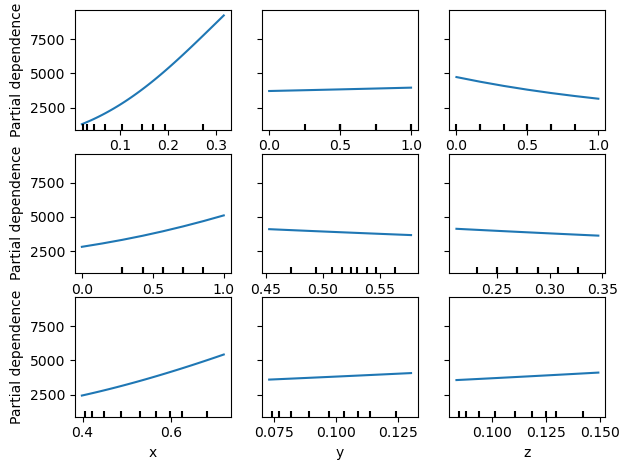

In [61]:
# PDP Generation
keras_wrapper = KerasRegressorWrapper(build_fn=create_nn_model)
keras_wrapper.fit(x_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)
features = list(range(X.shape[1]))
PartialDependenceDisplay.from_estimator(
    keras_wrapper,
    x_test_scaled,
    features=features,
    feature_names=X.columns,
    grid_resolution=50
)
plt.tight_layout()
plt.show()


1) PDPs help visualize the marginal effect one or two features have on the model's predictions.
2) They show how the average prediction of the model changes as we change the value of a specific feature while keeping all other features fixed.
3) Interpreting the Plots:
 * X: The y-axis is increasing as the x-axis increases. This suggests that as the value of feature "X" increases, the model's predictions tend to increase as well.
 * Y: The y-axis is flat. This indicates that the model's predictions are not significantly affected by changes in feature "Y". In other words, feature "Y" seems to have little or no influence on the model's output.
 * Z: The y-axis is increasing as the z-axis increases. This suggests that as the value of feature "Z" increases, the model's predictions also tend to increase. However, the rate of increase seems to slow down towards the higher end of the z-axis values.
Additional Insights:
 * Feature Importance: Based on these plots, "X" and "Z" seem to have a stronger influence on the model's predictions compared to "Y".
